/root/sdrfly


SKIQ[53612]: <WARNING> Process 53563 had owned lock but no longer exists, forcing unlock
SKIQ[53612]: <INFO> libsidekiq v4.18.1 (g58be05ffb)
python3[53612]: [card-0] <INFO> Sidekiq card is serial number=7G2Y, hardware M2 C (rev C), product SKIQ-M2-002 (M.2) (part ES01420*-C0-00)
python3[53612]: [card-0] <INFO> Firmware v2.9
python3[53612]: [card-0] <INFO> Sidekiq: FPGA v3.18.1, (date 24052819, FIFO size 16k)
python3[53612]: [card-0] <INFO> Sidekiq card is configured for an internal reference clock
python3[53612]: [card-0] <INFO> Loading calibration data for Sidekiq M.2
python3[53612]: [card-0] <INFO> RF IC version 5.5.1
python3[53612]: [card-0] <INFO> Number of tx channels supported 1, number of rx channels supported 1
python3[53612]: [card-0] <INFO> Default warp voltage not currently stored (user)
[INFO] Using format CF32.
[INFO] Starting RX Sidekiq Thread
[INFO] Opening HackRF One #0 88869dc2a59211b...


Transmitted 131072 samples instead of 4000000
Transmitting CW signal...
Receiving data from SDR...
Data reception complete. Plotting...


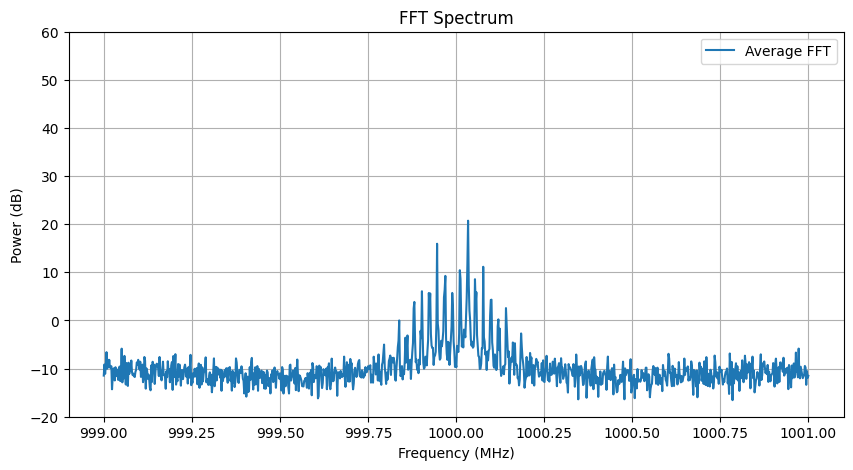

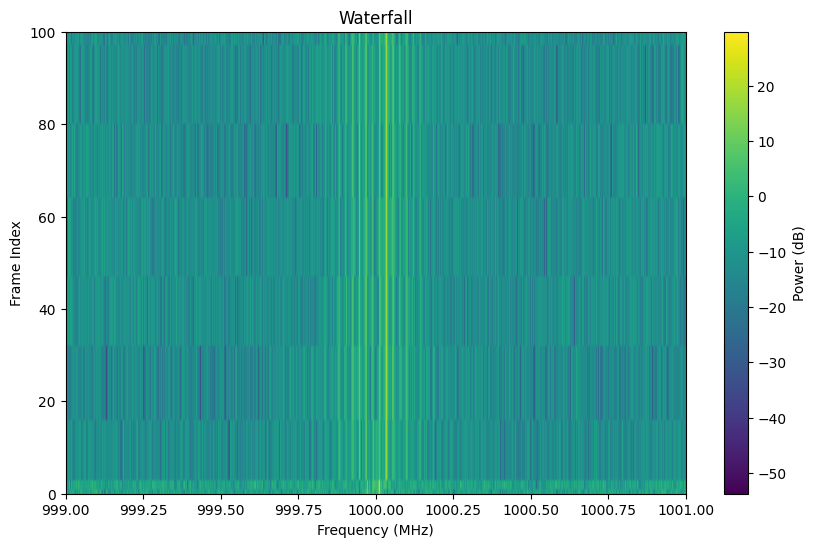

Receiving data from SDR after stopping transmission...
Data reception complete. Plotting...


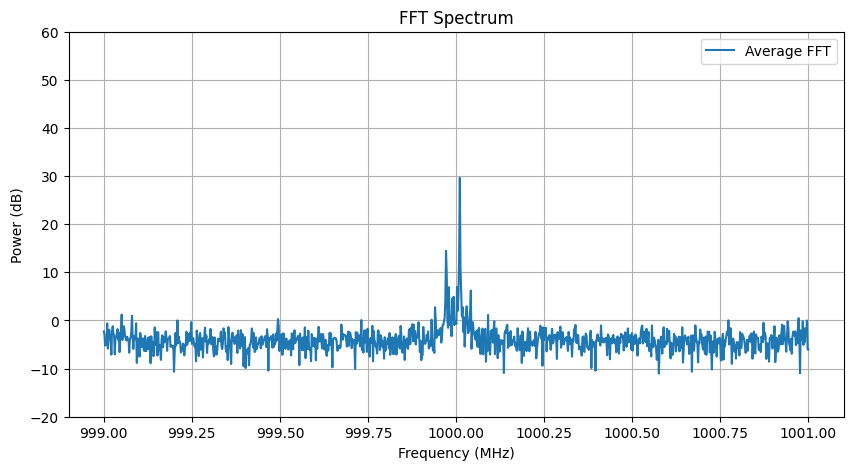

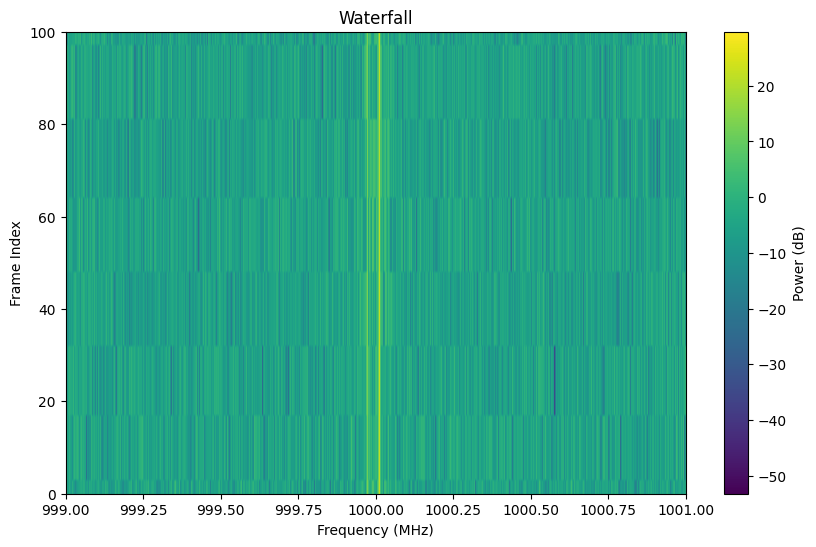

Done.


In [1]:
# SDR Data Reception and Visualization

import numpy as np
import matplotlib.pyplot as plt
from sdrfly.sdr.sdr_generic import SDRGeneric
import time

# SDR Settings
CENTER_FREQ = 1000e6  # Center frequency in Hz
SAMPLE_RATE = 2e6    # Sample rate in Hz
BANDWIDTH = SAMPLE_RATE      # Bandwidth in Hz
GAIN = 76             # Gain
SAMPLE_SIZE = 1024    # Number of samples per FFT frame
NUM_FRAMES = 100      # Number of frames for the waterfall plot

# Instantiate SDRGeneric for reception
sdr = SDRGeneric(
    "sidekiq",
    center_freq=CENTER_FREQ,
    sample_rate=SAMPLE_RATE,
    bandwidth=BANDWIDTH,
    gain=GAIN,
    size=SAMPLE_SIZE
)
sdr.start()

# Instantiate SDRGeneric for transmission
sdr_tx = SDRGeneric(
    "hackrf",
    center_freq=CENTER_FREQ,
    sample_rate=SAMPLE_RATE,
    bandwidth=BANDWIDTH,
    gain=GAIN,
    size=SAMPLE_SIZE
)

# Generate a CW signal
def generate_cw_signal(offset_freq, sample_rate, duration=1):
    """
    Generate a Continuous Wave (CW) signal offset from DC.

    Parameters:
        offset_freq (float): Frequency offset from DC in Hz (e.g., 5 MHz).
        sample_rate (float): Sample rate in Hz.
        duration (float): Duration of the signal in seconds.

    Returns:
        np.array: Complex CW signal (IQ samples).
    """
    t = np.arange(0, duration, 1 / sample_rate)
    cw_signal = np.exp(2j * np.pi * offset_freq * t)  # Generate a complex sinusoid
    return cw_signal

# Generate and transmit CW signal
OFFSET_FREQ = 0.25e6  # Offset from DC in Hz (e.g., 5 MHz)
cw_signal = generate_cw_signal(OFFSET_FREQ, SAMPLE_RATE, duration=2)  # CW offset from DC
sdr_tx.transmit_samples(cw_signal)

# Receive and process data
def receive_and_process_data(num_frames):
    fft_data = []
    for _ in range(num_frames):
        iq_samples = sdr.get_latest_samples()  # Receive IQ samples
        fft_frame = np.abs(np.fft.fftshift(np.fft.fft(iq_samples)))  # Compute FFT
        fft_data.append(fft_frame)
    return np.array(fft_data)

# Plot the FFT and Waterfall
def plot_fft_and_waterfall(fft_data):
    # Plot FFT
    avg_fft = np.mean(fft_data, axis=0)
    freqs = np.linspace(-SAMPLE_RATE / 2, SAMPLE_RATE / 2, SAMPLE_SIZE) + CENTER_FREQ
    plt.figure(figsize=(10, 5))
    plt.plot(freqs / 1e6, 20 * np.log10(avg_fft), label="Average FFT")
    plt.title("FFT Spectrum")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (dB)")
    plt.grid(True)
    plt.ylim(-20, 60)
    plt.legend()
    plt.show()

    # Plot Waterfall
    plt.figure(figsize=(10, 6))
    plt.imshow(
        20 * np.log10(fft_data),
        aspect="auto",
        extent=[freqs[0] / 1e6, freqs[-1] / 1e6, 0, fft_data.shape[0]],
        cmap="viridis",
        origin="lower"
    )
    plt.title("Waterfall")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Frame Index")
    plt.colorbar(label="Power (dB)")
    plt.show()
    return avg_fft

# Main Functionality
if __name__ == "__main__":
    print("Transmitting CW signal...")
    print("Receiving data from SDR...")
    fft_data = receive_and_process_data(NUM_FRAMES)
    print("Data reception complete. Plotting...")
    avg_fft = plot_fft_and_waterfall(fft_data)
    sdr_tx.stop_transmission()
    time.sleep(1)
    print("Receiving data from SDR after stopping transmission...")
    fft_data = receive_and_process_data(NUM_FRAMES)
    print("Data reception complete. Plotting...")
    avg_fft = plot_fft_and_waterfall(fft_data)
    print("Done.")


Starting transmission and reception loop...
Transmitting and receiving modulation: QPSK, SNR: 18 dB
Transmitting signal asynchronously for 1 seconds...
Asynchronous transmission complete.
Transmission stopped asynchronously.


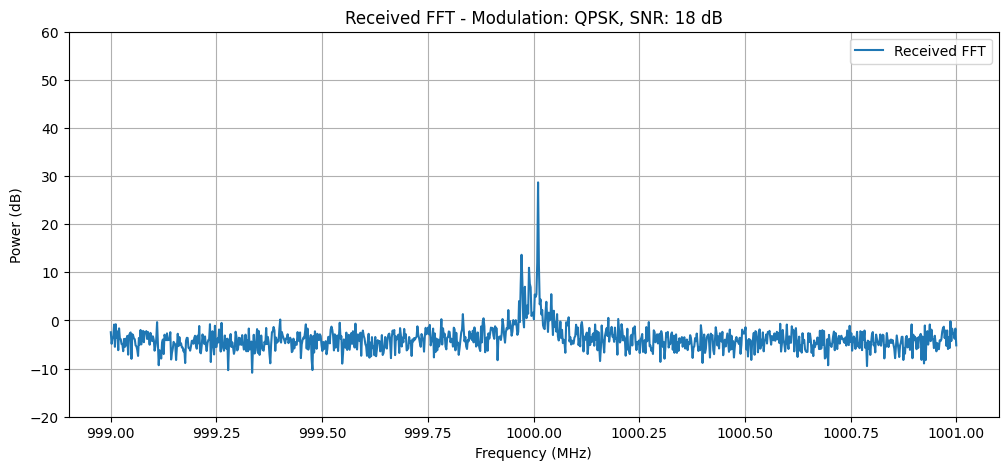

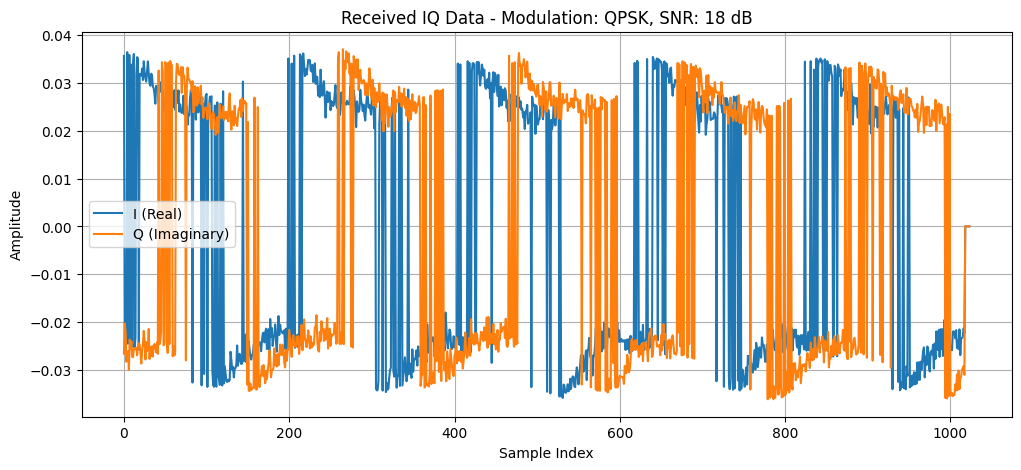

Transmitting and receiving modulation: PAM4, SNR: 18 dB
Transmitting signal asynchronously for 1 seconds...
Asynchronous transmission complete.
Transmission stopped asynchronously.


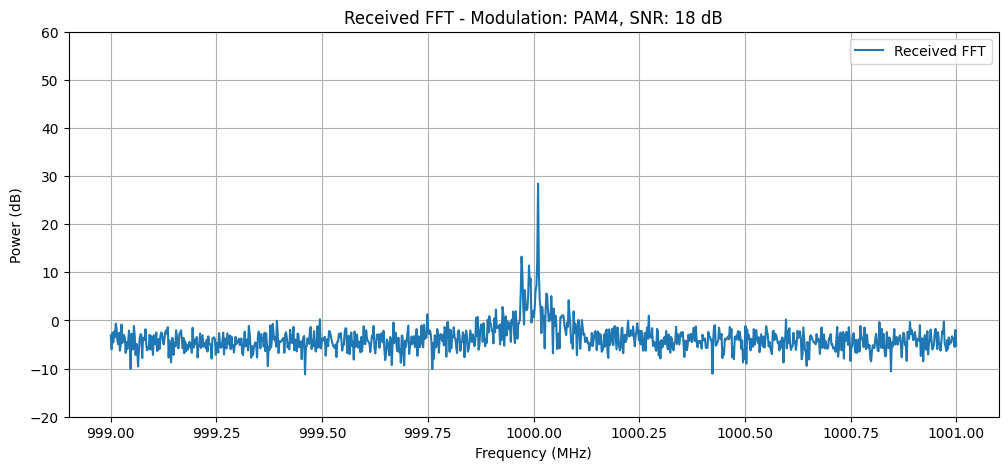

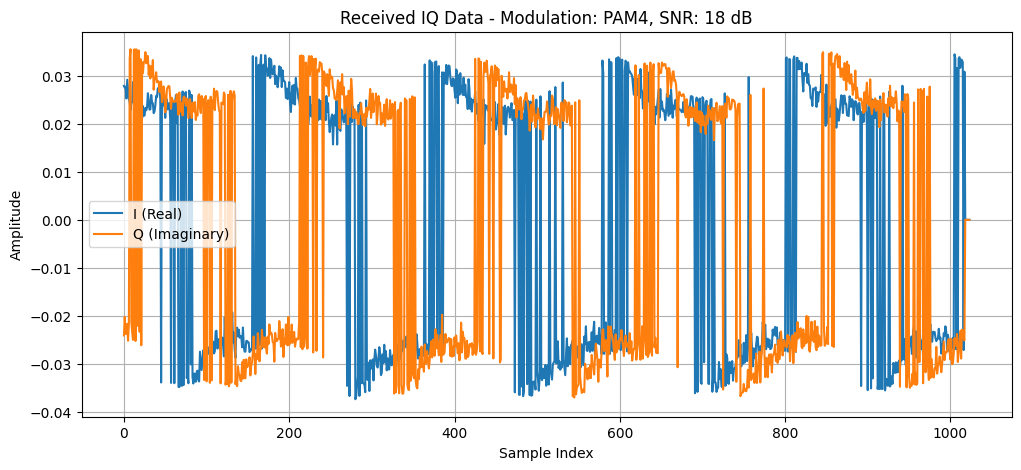

Transmitting and receiving modulation: AM-DSB, SNR: 18 dB
Transmitting signal asynchronously for 1 seconds...
Asynchronous transmission complete.
Transmission stopped asynchronously.


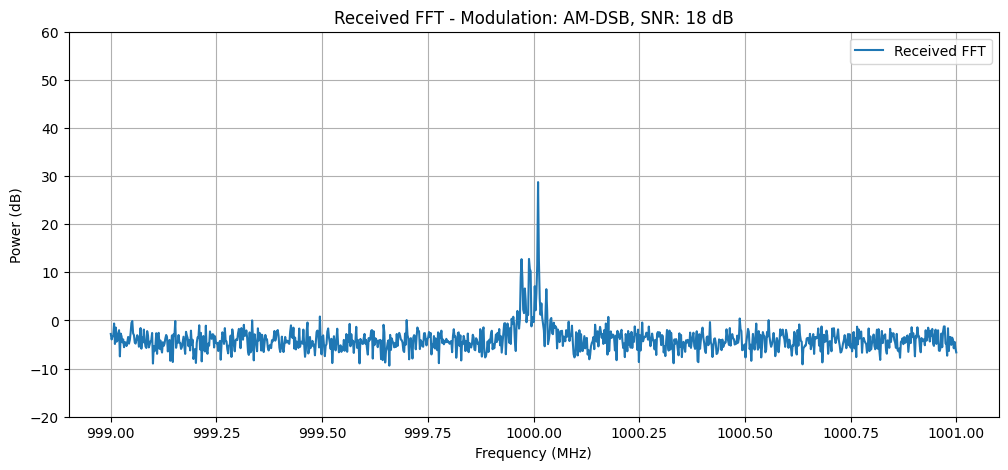

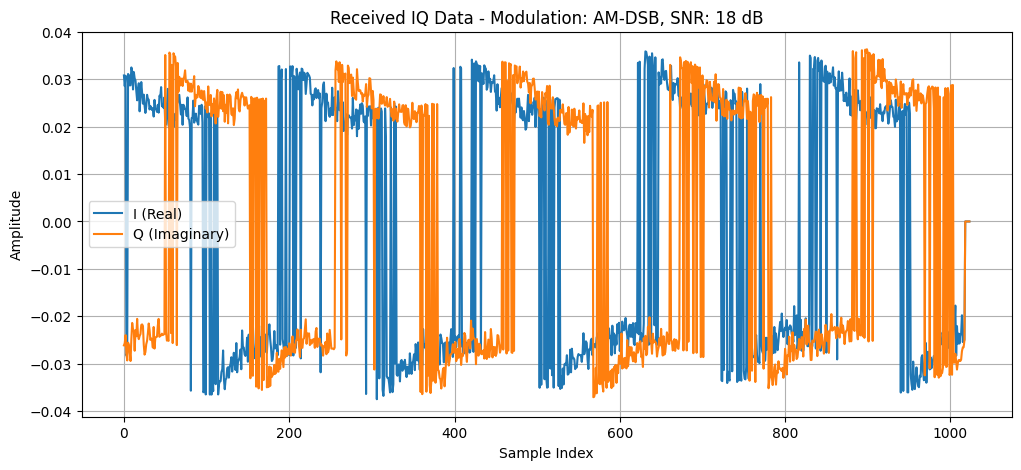

Transmitting and receiving modulation: GFSK, SNR: 18 dB
Transmitting signal asynchronously for 1 seconds...
Asynchronous transmission complete.
Transmission stopped asynchronously.


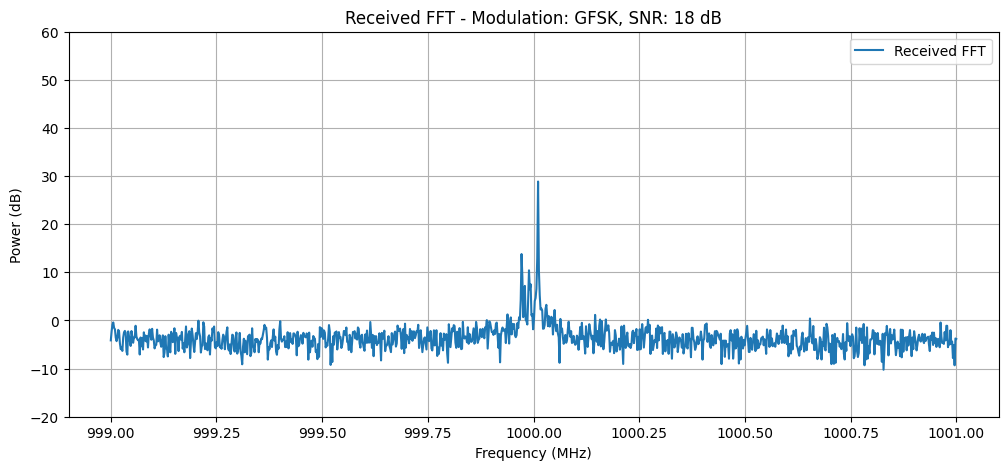

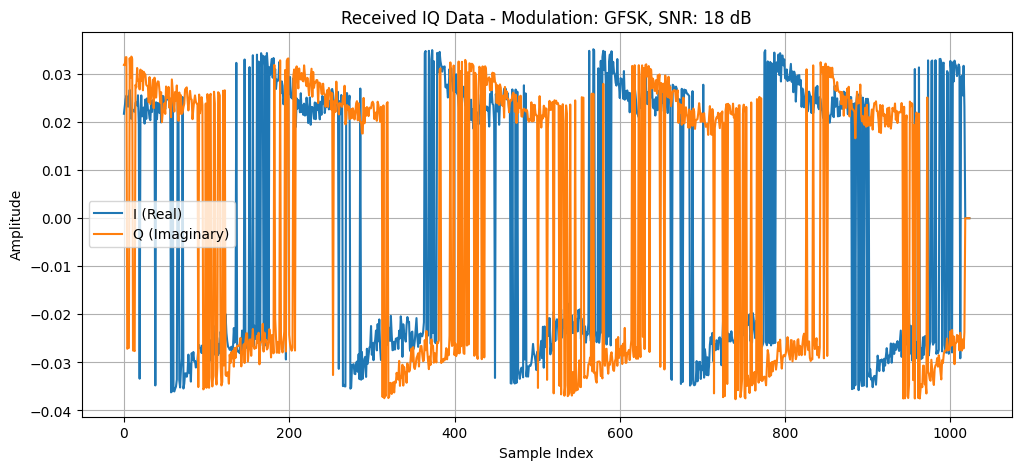

Transmitting and receiving modulation: QAM64, SNR: 18 dB
Transmitting signal asynchronously for 1 seconds...
Asynchronous transmission complete.
Transmission stopped asynchronously.


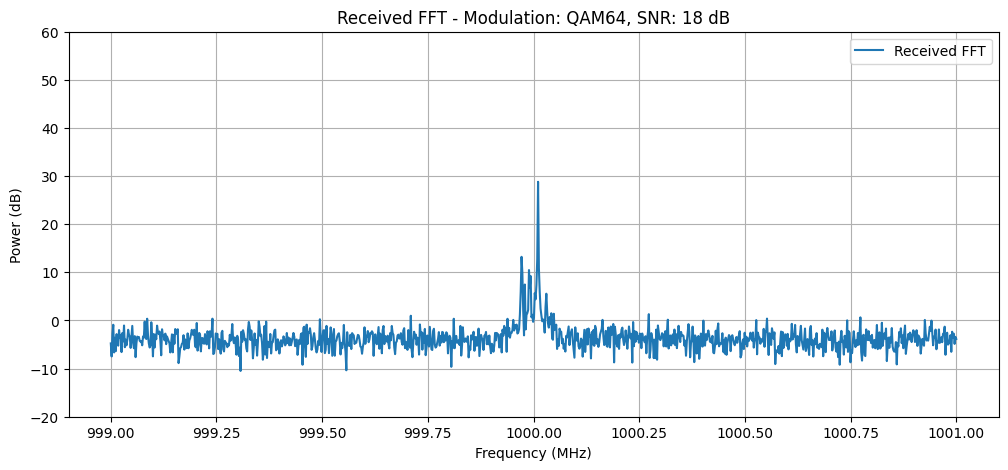

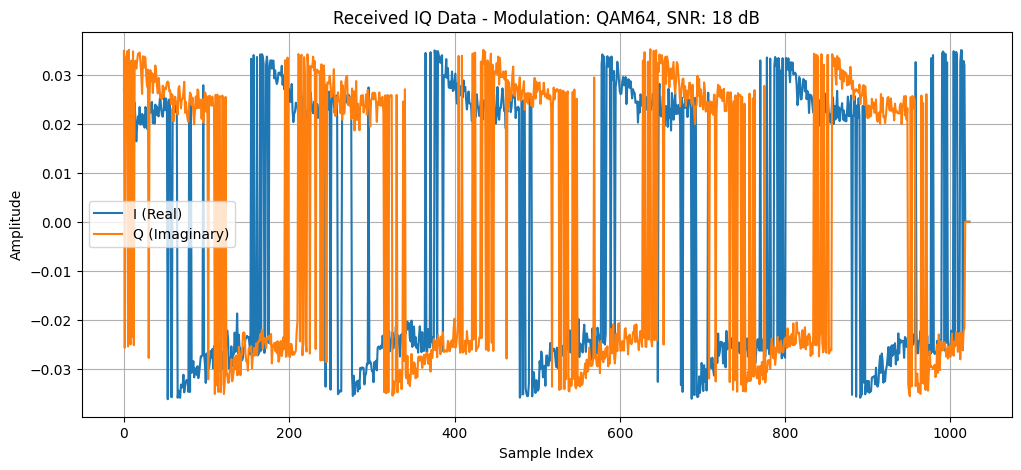

Transmitting and receiving modulation: AM-SSB, SNR: 18 dB
Transmitting signal asynchronously for 1 seconds...
Transmission and reception loop interrupted by user.
Asynchronous transmission complete.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
from threading import Event

# Load the RML2016.10a_dict.pkl file
with open(os.path.join("..","RML2016.10a_dict.pkl"), "rb") as f:
    dataset = pickle.load(f, encoding="latin1")  # Use 'latin1' encoding to avoid Unicode errors

# Extract the highest SNR signals for each modulation type
def get_highest_snr_signals(data):
    highest_snr_signals = {}
    for key, signals in data.items():
        mod_type, snr = key
        if (
            mod_type not in highest_snr_signals
            or snr > highest_snr_signals[mod_type][1]
        ):
            highest_snr_signals[mod_type] = (signals[0], snr)  # Store the signal and SNR
    return highest_snr_signals

highest_snr_signals = get_highest_snr_signals(dataset)

# Transmit the signal asynchronously
def transmit_signal_async(sdr_tx, signal, duration=1, stop_event=None):
    """
    Transmit a signal asynchronously using the SDR.

    Parameters:
        sdr_tx: SDR object for transmission.
        signal: Complex IQ signal to be transmitted.
        duration: Duration of the transmission in seconds.
        stop_event: Optional threading event to stop the transmission.
    """
    num_repeats = int(sdr_tx.sample_rate * duration / len(signal))
    signal_repeated = np.tile(signal, num_repeats)

    print(f"Transmitting signal asynchronously for {duration} seconds...")
    sdr_tx.transmit_data_async(signal_repeated, duration=duration)

    # Optionally stop the transmission early if an event is set
    if stop_event:
        stop_event.wait(timeout=duration)
        sdr_tx.stop_transmission()
        print("Transmission stopped asynchronously.")

# Receive and process data
def receive_signal(sdr, num_frames=100):
    """
    Receive and process data using the SDR.

    Parameters:
        sdr: SDR object for reception.
        num_frames: Number of frames to receive.

    Returns:
        np.array: Received FFT data.
    """
    fft_data = []
    for _ in range(num_frames):
        iq_samples = sdr.get_latest_samples()  # Receive IQ samples
        fft_frame = np.abs(np.fft.fftshift(np.fft.fft(iq_samples)))  # Compute FFT
        fft_data.append(fft_frame)
    return np.array(fft_data), iq_samples

# Plot received data
def plot_received_data(fft_data, iq_samples, mod_type, snr):
    """
    Plot the received FFT and IQ data.

    Parameters:
        fft_data: FFT data to plot.
        iq_samples: IQ samples to plot.
        mod_type: Modulation type.
        snr: SNR of the transmitted signal.
    """
    avg_fft = np.mean(fft_data, axis=0)
    freqs = np.linspace(-sdr.sample_rate / 2, sdr.sample_rate / 2, sdr.size) + sdr.center_freq

    # Plot FFT
    plt.figure(figsize=(12, 5))
    plt.plot(freqs / 1e6, 20 * np.log10(avg_fft), label="Received FFT")
    plt.title(f"Received FFT - Modulation: {mod_type}, SNR: {snr} dB")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (dB)")
    plt.grid(True)
    plt.ylim(-20, 60)
    plt.legend()
    plt.show()

    # Plot IQ components
    real_part = np.real(iq_samples)
    imag_part = np.imag(iq_samples)

    plt.figure(figsize=(12, 5))
    plt.plot(real_part, label="I (Real)")
    plt.plot(imag_part, label="Q (Imaginary)")
    plt.title(f"Received IQ Data - Modulation: {mod_type}, SNR: {snr} dB")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.show()

# Main loop
if __name__ == "__main__":
    print("Starting transmission and reception loop...")

    try:
        stop_event = Event()  # Event to handle interrupt
        while True:
            for mod_type, (signal, snr) in highest_snr_signals.items():
                print(f"Transmitting and receiving modulation: {mod_type}, SNR: {snr} dB")

                # Prepare the complex signal
                real_part = signal[0]  # I-component (real)
                imag_part = signal[1]  # Q-component (imaginary)
                complex_signal = real_part + 1j * imag_part  # Combine I and Q

                # Transmit the signal asynchronously
                transmit_signal_async(sdr_tx, complex_signal, duration=1, stop_event=stop_event)

                # Receive the signal
                fft_data, iq_samples = receive_signal(sdr)

                # Plot the received data
                plot_received_data(fft_data, iq_samples, mod_type, snr)
                
    except KeyboardInterrupt:
        print("Transmission and reception loop interrupted by user.")
        stop_event.set()
        sdr_tx.stop_transmission()


In [ ]:

sdr.stop()
sdr.close()
sdr_tx.close()